In [1]:
cd /engelhardt/home/jboen/Experiments/GPzoo/

/engelhardt/home/jboen/Experiments/GPzoo


In [2]:
import torch
import matplotlib.pyplot as plt
from torch import optim, distributions, nn
from tqdm.autonotebook import tqdm
from gpzoo.kernels import RBF
from gpzoo.gp import VNNGP, SVGP
from gpzoo.likelihoods import GaussianLikelihood

/tmp/ipykernel_7703/2282795513.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
import numpy as np
import time
import gc
import pickle as pk


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [126]:
def load_vnngp_model(N, k, load_model = True):

    if load_model:
        M = N
        kernel = RBF(sigma=1.0, lengthscale=5.0)
        gp = VNNGP(kernel, dim=1, M=M, jitter=1e-2)
        gp.Z = nn.Parameter(10.0*torch.rand((M, 1))-5.0) #choose inducing points
        model = GaussianLikelihood(gp)
        
        model.gp.K = k
    
        model.load_state_dict(torch.load("../models/vnngp_model_N={}_k={}.pth".format(N,k)))

    results = pk.load(open("../results/vnngp_results_k={}.pk".format(k), "rb"))
    results = results[N]

    if load_model:
        return model, results
    else:
        return results

def load_svgp_model(N, load_model = True):

    if load_model:
        M = N
        kernel = RBF(sigma=1.0, lengthscale=5.0)
        gp = SVGP(kernel, dim=1, M=M, jitter=1e-2)
        gp.Z = nn.Parameter(10.0*torch.rand((M, 1))-5.0) #choose inducing points
        model = GaussianLikelihood(gp)
        
        model.to(device)
    
        model.load_state_dict(torch.load("../models/svgp_model_N={}.pth".format(N)))

    results = pk.load(open("../results/svgp_results.pk", "rb"))
    results = results[N]

    if load_model:
        return model, results
    else:
        return results

def make_predictions(X_test, model):

    model.to(device)
    
    qF, _, _ = model.gp(X_test[:, None].to(device), verbose=False)
    mean_test = qF.mean.detach().cpu().numpy()
    std_test = qF.scale.detach().cpu().numpy()
    
    return mean_test, std_test

In [112]:
N = 2048
X = distributions.Uniform(-5, 5).sample((N, ))
y = 2*torch.sin(2*X) + distributions.Normal(0.0, 1.0).sample((N,))

X_train = (X[:, None]).to(device)
y_train = y.to(device)

X_test = torch.linspace(-6, 6, 150)

In [113]:
vnngp_results['time'][-1]

23.64824104309082

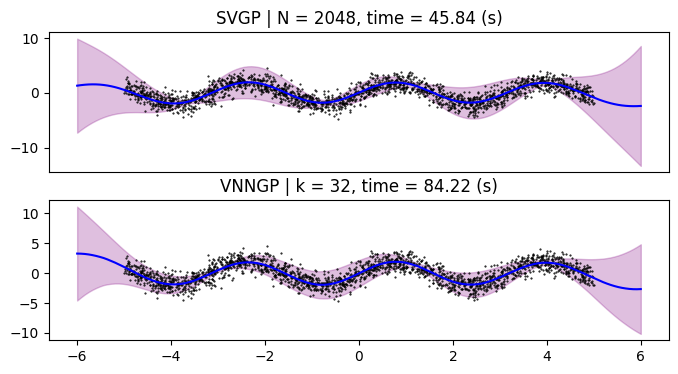

In [125]:
fig, axes = plt.subplots(nrows = 2, figsize = (8,4))

k = 32
vnngp_model, vnngp_results = load_vnngp_model(N, k)
svgp_model, svgp_results = load_svgp_model(N)

axes[0].plot(X, y, 'ko', markersize = 0.5)
axes[1].plot(X, y, 'ko', markersize = 0.5)
axes[0].set_xticks([])

mean, std = make_predictions(X_test, svgp_model)
axes[0].set_title("SVGP | N = {}, time = {:.2f} (s)".format(N, svgp_results['time'][-1]))
axes[0].plot(X_test, mean, 'b-')
axes[0].fill_between(X_test, mean - std, mean + std, alpha = 0.25, color = 'purple')

mean, std = make_predictions(X_test, vnngp_model)
axes[1].set_title("VNNGP | k = {}, time = {:.2f} (s)".format(k, vnngp_results['time'][-1]))
axes[1].plot(X_test, mean, 'b-')
axes[1].fill_between(X_test, mean - std, mean + std, alpha = 0.25, color = 'purple')

plt.savefig("../figs/comparison_N={}_k={}.png".format(N,k), dpi = 300, bbox_inches = "tight")

In [119]:
!nvidia-smi

Sun Dec 17 22:09:13 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A30                     Off | 00000000:65:00.0 Off |                    0 |
| N/A   23C    P0              32W / 165W |   8962MiB / 24576MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [133]:
start, end = 8, 12
N_list = np.logspace(start,end, num = (end - start)+1, base = 2).astype(int)

start, end = 0,5
k_list = np.logspace(start, end, num = (end - start)+1, base = 2).astype(int)

In [134]:
N = N_list[0]
print(N)

vnngp_results = load_vnngp_model(N, k)
svgp_results = load_svgp_model(N)

array([ 1,  2,  4,  8, 16, 32])

In [139]:
svgp_times = np.asarray([load_svgp_model(N, load_model = False)['time'][-1] for N in N_list])
vnngp_times = np.asarray([[load_vnngp_model(N, k, load_model = False)['time'][-1] for N in N_list] for k in k_list])


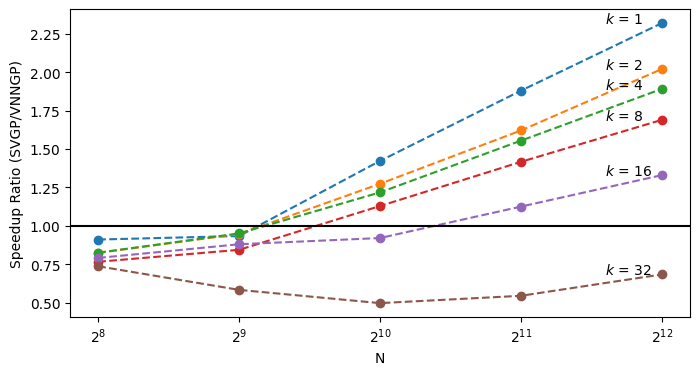

In [175]:
fig, axes = plt.subplots(figsize = (8,4))
axes.set_xscale('log', base = 2)

for idx, k in enumerate(k_list):
    #axes.plot(N_list, svgp_times/vnngp_times[idx].T, 'o--', label = r"$k$ = {}".format(k))
    
    x, y = N_list, svgp_times/vnngp_times[idx].T
    axes.plot(x, y, 'o--')
    plt.text(x[-1]-1000, y[-1], r"$k$ = {}".format(k))

axes.axhline(1.0, color = 'black')
axes.set_xlabel("N")
axes.set_ylabel("Speedup Ratio (SVGP/VNNGP)")

#axes.legend()
plt.savefig("../figs/speedup.png".format(N,k), dpi = 300, bbox_inches = "tight")